### 5.5) Gathering Input Graphs

In [56]:
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.5.1+cu124.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.5.1+cu124.html
!pip install torch-geometric

Looking in links: https://data.pyg.org/whl/torch-2.5.1+cu124.html
Looking in links: https://data.pyg.org/whl/torch-2.5.1+cu124.html


In [57]:
import torch
from torch_geometric.data import Data
from torch.serialization import add_safe_globals
import os

# Allow PyTorch to unpickle torch_geometric.data.Data objects
add_safe_globals([Data])

# Then load the files
graph_dir = "/kaggle/input/chicken-data-graph/graph_data_zip"
pt_files = [f for f in os.listdir(graph_dir) if f.endswith('.pt')]

graphs = [
    torch.load(os.path.join(graph_dir, f), weights_only=False)
    for f in pt_files
]

In [58]:
graphs

[Data(x=[571, 571], edge_index=[2, 513776], edge_attr=[513776, 4], y=[1]),
 Data(x=[609, 609], edge_index=[2, 223972], edge_attr=[223972, 4], y=[1]),
 Data(x=[573, 573], edge_index=[2, 133468], edge_attr=[133468, 4], y=[1]),
 Data(x=[486, 486], edge_index=[2, 263368], edge_attr=[263368, 4], y=[1]),
 Data(x=[591, 591], edge_index=[2, 571268], edge_attr=[571268, 4], y=[1]),
 Data(x=[574, 574], edge_index=[2, 512400], edge_attr=[512400, 4], y=[1]),
 Data(x=[608, 608], edge_index=[2, 475792], edge_attr=[475792, 4], y=[1]),
 Data(x=[577, 577], edge_index=[2, 429858], edge_attr=[429858, 4], y=[1]),
 Data(x=[542, 542], edge_index=[2, 74818], edge_attr=[74818, 4], y=[1]),
 Data(x=[395, 395], edge_index=[2, 197910], edge_attr=[197910, 4], y=[1]),
 Data(x=[523, 523], edge_index=[2, 333072], edge_attr=[333072, 4], y=[1]),
 Data(x=[477, 477], edge_index=[2, 256828], edge_attr=[256828, 4], y=[1]),
 Data(x=[443, 443], edge_index=[2, 167174], edge_attr=[167174, 4], y=[1]),
 Data(x=[567, 567], edge_in

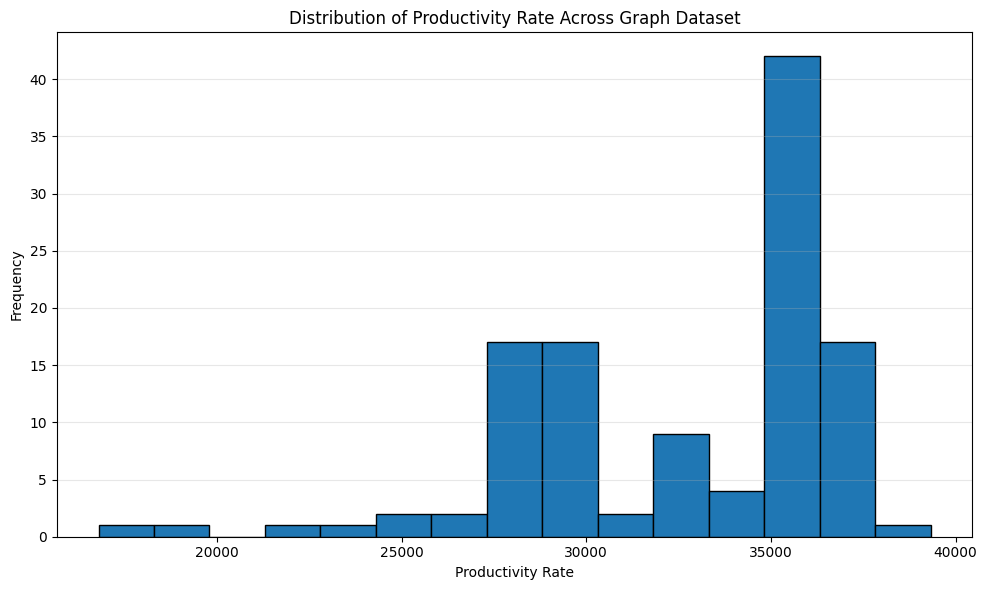

In [59]:
import pandas as pd
import matplotlib.pyplot as plt

rates = []
for graph in graphs:
    if hasattr(graph, 'y'):
        val = graph.y.item() if graph.y.numel() == 1 else float(graph.y[0])
        rates.append(val)

plt.figure(figsize=(10, 6))
plt.hist(rates, bins=15, edgecolor='black')
plt.xlabel("Productivity Rate")
plt.ylabel("Frequency")
plt.title("Distribution of Productivity Rate Across Graph Dataset")
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## Interpretation

The histogram illustrates the distribution of productivity rates across all graph samples in our dataset. From this distribution it can be deducted that the majority of graphs fall within the upper range of productivity, particularly between approximately 35000 and 37000. This concentration suggests that most units are performing at a high level. 
Another smaller but still noticeable cluster occurs between 28000 and 30000, indicating a secondary group of moderately productive entities.
In contrast, the left tail of the distribution shows only a handful of low-productivity cases, with values dropping as far down as around 17000. These could be edge cases, anomalies, or instances of failure that deviate substantially from the norm.

In [60]:
# padding so model can expect a fixed set of dimensions from graphs

max_node_dim = max(g.x.shape[1] for g in graphs)
max_edge_dim = max(g.edge_attr.shape[1] for g in graphs)

def pad_features(graph, max_node_dim, max_edge_dim):
    # Pad node features
    node_feat = graph.x
    if node_feat.shape[1] < max_node_dim:
        pad_size = max_node_dim - node_feat.shape[1]
        padding = torch.zeros((node_feat.shape[0], pad_size), dtype=node_feat.dtype)
        graph.x = torch.cat([node_feat, padding], dim=1)
    
    # Pad edge features
    edge_feat = graph.edge_attr
    if edge_feat.shape[1] < max_edge_dim:
        pad_size = max_edge_dim - edge_feat.shape[1]
        padding = torch.zeros((edge_feat.shape[0], pad_size), dtype=edge_feat.dtype)
        graph.edge_attr = torch.cat([edge_feat, padding], dim=1)
    
    return graph

In [61]:
graphs_padded = [pad_features(g, max_node_dim, max_edge_dim) for g in graphs]

### 6) Create GAT Model for Graph Regression¶

GAT model takes graph as input, applies GAT layers to learn node embeddings, aggregates (mean pooling or attention pooling) to a graph level embedding, and passes that to fully connected layers to predict a single value (productivity)

In [62]:
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_mean_pool

class GATGraphRegressor(torch.nn.Module):
    def __init__(self, in_node_feats, in_edge_feats, hidden_dim=64, heads=4):
        super(GATGraphRegressor, self).__init__()

        # GATConv layers: use edge features via edge weights, if needed
        self.gat1 = GATConv(in_node_feats, hidden_dim, heads=heads, concat=True, dropout=0.2)
        self.gat2 = GATConv(hidden_dim * heads, hidden_dim, heads=1, concat=True, dropout=0.2)

        # Optional MLP after global pooling
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, 1)  # Output is a single scalar (regression)
        )

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch

        # GAT layers (edge_attr is not directly used by GATConv, unless customized)
        x = self.gat1(x, edge_index)
        x = F.elu(x)
        x = self.gat2(x, edge_index)
        x = F.elu(x)

        # Graph-level pooling (mean of all node embeddings in each graph)
        x = global_mean_pool(x, batch)

        # MLP to predict scalar output
        return self.mlp(x).squeeze(1)  # shape: [batch_size]

### 7) Train the model

Split dataset int 80/20 train/test and use MSE loss as we're working with a regression problem.

Use Adam optimizer and track validation loss

Maybe consider early stopping to prevent overfitting

In [63]:
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split

# Split dataset
train_data, test_data = train_test_split(graphs_padded, test_size=0.2, random_state=0)

train_loader = DataLoader(
    train_data,
    batch_size=1,  # smaller batch size to reduce GPU memory use
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True,
)

test_loader = DataLoader(
    test_data,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True,
)

In [64]:
import torch.nn as nn
import torch.optim as optim

model = GATGraphRegressor(in_node_feats=max_node_dim, in_edge_feats=max_edge_dim)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [65]:
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

best_val_loss = float('inf')
patience = 10
patience_counter = 0

for epoch in range(100):  # max 100 epochs
    torch.cuda.empty_cache()
    model.train()
    train_losses = []

    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch)  # <-- Fix here
        loss = criterion(out, batch.y.view(-1, 1))
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    # Validation loss
    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            out = model(batch)  # <-- Fix here too
            loss = criterion(out, batch.y.view(-1, 1))
            val_losses.append(loss.item())

    avg_train_loss = np.mean(train_losses)
    avg_val_loss = np.mean(val_losses)
    print(f"Epoch {epoch} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model_mean.pt")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0 | Train Loss: 1078500999.9140 | Val Loss: 1120508333.3333
Epoch 1 | Train Loss: 958964070.1935 | Val Loss: 800515694.6667
Epoch 2 | Train Loss: 399464380.6371 | Val Loss: 100886982.5104
Epoch 3 | Train Loss: 22981233.1375 | Val Loss: 15199291.4727
Epoch 4 | Train Loss: 19808761.0293 | Val Loss: 19123036.1927
Epoch 5 | Train Loss: 19980860.8983 | Val Loss: 18979770.3177
Epoch 6 | Train Loss: 18889736.1656 | Val Loss: 19506498.0143
Epoch 7 | Train Loss: 19194945.9146 | Val Loss: 16167116.4115
Epoch 8 | Train Loss: 18706752.0412 | Val Loss: 17996180.1302
Epoch 9 | Train Loss: 19048575.6721 | Val Loss: 20437692.7188
Epoch 10 | Train Loss: 18576131.3721 | Val Loss: 15545195.4557
Epoch 11 | Train Loss: 18523349.3601 | Val Loss: 19681003.5156
Epoch 12 | Train Loss: 20227204.1325 | Val Loss: 16066104.9271
Epoch 13 | Train Loss: 20058068.1117 | Val Loss: 16943190.4635
Early stopping triggered.


### 8) Evaluate and Fine-tune

Report RMSE and MAE metrics

Try different GAT settings: number of heads, depth

Try different pooling strategies

In [66]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

model.load_state_dict(torch.load("best_model_mean.pt"))
model.eval()

all_preds = []
all_targets = []

with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        out = model(batch)  # pass batch as a whole
        all_preds.extend(out.cpu().numpy())
        all_targets.extend(batch.y.view(-1).cpu().numpy())  # flatten targets

# Compute metrics
rmse = mean_squared_error(all_targets, all_preds, squared=False)
mae = mean_absolute_error(all_targets, all_preds)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

RMSE: 3898.6265
MAE: 3693.9402


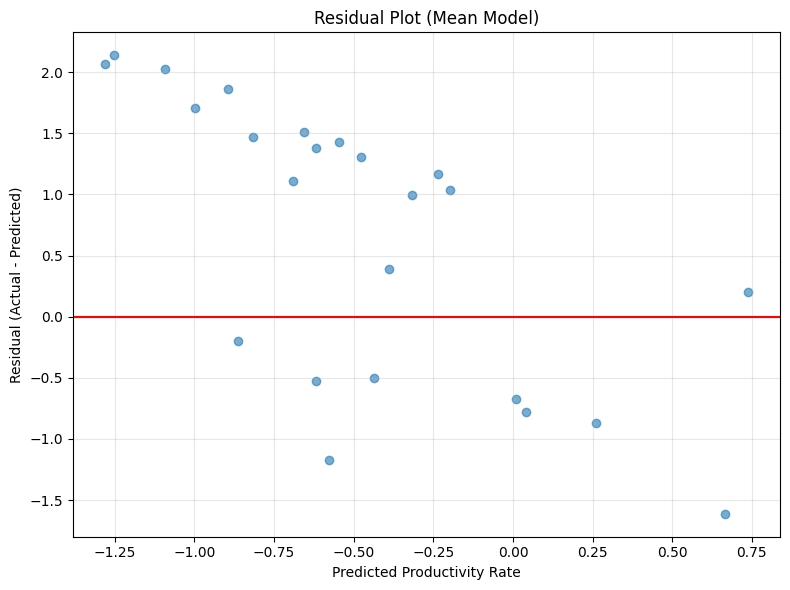

In [96]:
residuals = np.array(all_targets) - np.array(all_preds)

plt.figure(figsize=(8, 6))
plt.scatter(all_preds, residuals, alpha=0.6)
plt.axhline(0, color='red')
plt.xlabel("Predicted Productivity Rate")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residual Plot (Mean Model)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

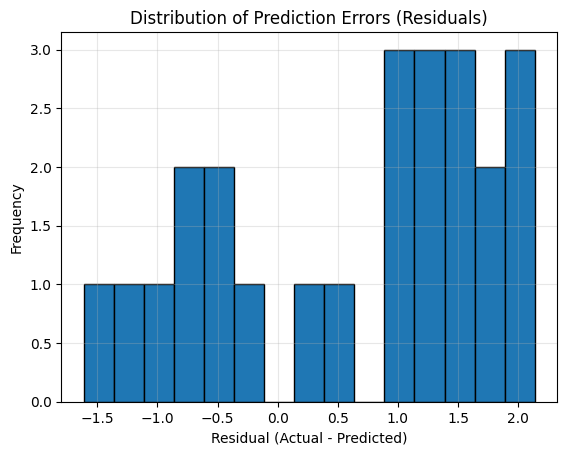

In [97]:
plt.hist(residuals, bins=15, edgecolor='black')
plt.title("Distribution of Prediction Errors (Residuals)")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.show()

In [70]:
import pandas as pd

target = pd.read_csv("/kaggle/input/production/production_net.csv", sep=";")
eggs_per_day_df = target[["date", "Total.eggs"]].rename(columns={"Total.eggs": "total eggs"})
eggs_per_day_df.head(5)

,date,total eggs
0,2017-02-27,36931
1,2017-03-01,36654
2,2017-04-25,35752
3,2017-07-12,33954
4,2017-07-22,33296


In [71]:
mean_eggs = eggs_per_day_df["total eggs"].mean()
std_eggs = eggs_per_day_df["total eggs"].std()

print(f"Mean of total eggs: {mean_eggs:.2f}")
print(f"Standard deviation of total eggs: {std_eggs:.2f}")

Mean of total eggs: 32796.07
Standard deviation of total eggs: 4146.78


Use global_max_pool instead of global_mean_pool

In [72]:
from torch_geometric.nn import global_max_pool

class GATGraphRegressor(torch.nn.Module):
    def __init__(self, in_node_feats, in_edge_feats, hidden_dim=64, heads=4):
        super(GATGraphRegressor, self).__init__()

        self.gat1 = GATConv(in_node_feats, hidden_dim, heads=heads, concat=True, dropout=0.2)
        self.gat2 = GATConv(hidden_dim * heads, hidden_dim, heads=1, concat=True, dropout=0.2)

        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, 1)
        )

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch
        x = self.gat1(x, edge_index)
        x = F.elu(x)
        x = self.gat2(x, edge_index)
        x = F.elu(x)
        x = global_max_pool(x, batch)
        return self.mlp(x).squeeze(1)  # shape: [batch_size]

In [73]:
from sklearn.model_selection import train_test_split

# Normalize y before splitting
ys_all = [g.y.item() for g in graphs_padded]
mean_y = np.mean(ys_all)
std_y = np.std(ys_all)

global_mean_y = mean_y
global_std_y = std_y

for g in graphs_padded:
    g.y = torch.tensor([(g.y.item() - mean_y) / std_y], dtype=torch.float)

train_data, test_data = train_test_split(graphs_padded, test_size=0.2, random_state=0)

Train and evaluate

In [74]:
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split

train_loader = DataLoader(
    train_data,
    batch_size=1,  # smaller batch size to reduce GPU memory use
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True,
)

test_loader = DataLoader(
    test_data,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True,
)

In [75]:
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

best_val_loss = float('inf')
patience = 10
patience_counter = 0

for epoch in range(100):  # max 100 epochs
    torch.cuda.empty_cache()
    model.train()
    train_losses = []

    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch)  # <-- Fix here
        loss = criterion(out, batch.y.view(-1, 1))
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    # Validation loss
    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            out = model(batch)  # <-- Fix here too
            loss = criterion(out, batch.y.view(-1, 1))
            val_losses.append(loss.item())

    avg_train_loss = np.mean(train_losses)
    avg_val_loss = np.mean(val_losses)
    print(f"Epoch {epoch} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model_max.pt")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0 | Train Loss: 320470195.0108 | Val Loss: 86916425.3333
Epoch 1 | Train Loss: 59099852.0000 | Val Loss: 38498627.5000
Epoch 2 | Train Loss: 27168614.5054 | Val Loss: 15074884.9167
Epoch 3 | Train Loss: 8434653.4140 | Val Loss: 3400696.8542
Epoch 4 | Train Loss: 1570889.3219 | Val Loss: 339916.9440
Epoch 5 | Train Loss: 72025.5646 | Val Loss: 82.6103
Epoch 6 | Train Loss: 10.6643 | Val Loss: 4.0654
Epoch 7 | Train Loss: 2.0373 | Val Loss: 4.0792
Epoch 8 | Train Loss: 2.3383 | Val Loss: 3.3398
Epoch 9 | Train Loss: 2.2157 | Val Loss: 3.3027
Epoch 10 | Train Loss: 2.2124 | Val Loss: 4.2623
Epoch 11 | Train Loss: 2.2128 | Val Loss: 3.7484
Epoch 12 | Train Loss: 2.0435 | Val Loss: 2.7226
Epoch 13 | Train Loss: 1.9554 | Val Loss: 3.7543
Epoch 14 | Train Loss: 2.4247 | Val Loss: 3.2264
Epoch 15 | Train Loss: 2.0195 | Val Loss: 3.4174
Epoch 16 | Train Loss: 2.3088 | Val Loss: 2.4359
Epoch 17 | Train Loss: 2.0634 | Val Loss: 3.8082
Epoch 18 | Train Loss: 2.2197 | Val Loss: 2.8668
Epoch 1

In [76]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

model.load_state_dict(torch.load("best_model_max.pt"))
model.eval()

all_preds = []
all_targets = []

with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        out = model(batch)  # pass batch as a whole
        all_preds.extend(out.cpu().numpy())
        all_targets.extend(batch.y.view(-1).cpu().numpy())  # flatten targets

# Compute metrics
rmse = mean_squared_error(all_targets, all_preds, squared=False)
mae = mean_absolute_error(all_targets, all_preds)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

RMSE: 1.5607
MAE: 1.3349


Use now globalAttention

In [80]:
from torch_geometric.nn import GlobalAttention

class GATGraphRegressor(torch.nn.Module):
    def __init__(self, in_node_feats, in_edge_feats, hidden_dim=64, heads=4):
        super(GATGraphRegressor, self).__init__()

        self.gat1 = GATConv(in_node_feats, hidden_dim, heads=heads, concat=True, dropout=0.2)
        self.gat2 = GATConv(hidden_dim * heads, hidden_dim, heads=1, concat=True, dropout=0.2)

        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, 1)
        )

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch
        x = self.gat1(x, edge_index)
        x = F.elu(x)
        x = self.gat2(x, edge_index)
        x = F.elu(x)
        x = self.att_pool(x, batch)
        return self.mlp(x).squeeze(1)  # shape: [batch_size]

In [81]:
from sklearn.model_selection import train_test_split

# Normalize y before splitting
ys_all = [g.y.item() for g in graphs_padded]
mean_y = np.mean(ys_all)
std_y = np.std(ys_all)

global_mean_y = mean_y
global_std_y = std_y

for g in graphs_padded:
    g.y = torch.tensor([(g.y.item() - mean_y) / std_y], dtype=torch.float)

train_data, test_data = train_test_split(graphs_padded, test_size=0.2, random_state=0)

In [82]:
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split

train_loader = DataLoader(
    train_data,
    batch_size=1,  # smaller batch size to reduce GPU memory use
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True,
)

test_loader = DataLoader(
    test_data,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True,
)

In [83]:
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

best_val_loss = float('inf')
patience = 10
patience_counter = 0

for epoch in range(100):  # max 100 epochs
    torch.cuda.empty_cache()
    model.train()
    train_losses = []

    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch)  # <-- Fix here
        loss = criterion(out, batch.y.view(-1))
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    # Validation loss
    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            out = model(batch)  # <-- Fix here too
            loss = criterion(out, batch.y.view(-1))
            val_losses.append(loss.item())

    avg_train_loss = np.mean(train_losses)
    avg_val_loss = np.mean(val_losses)
    print(f"Epoch {epoch} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model_ga.pt")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break


Epoch 0 | Train Loss: 2.1889 | Val Loss: 2.5983
Epoch 1 | Train Loss: 2.6692 | Val Loss: 4.3561
Epoch 2 | Train Loss: 2.3271 | Val Loss: 3.5483
Epoch 3 | Train Loss: 2.4672 | Val Loss: 3.3040
Epoch 4 | Train Loss: 2.2802 | Val Loss: 5.6838
Epoch 5 | Train Loss: 2.2918 | Val Loss: 3.4137
Epoch 6 | Train Loss: 2.6112 | Val Loss: 2.8461
Epoch 7 | Train Loss: 2.3520 | Val Loss: 3.4845
Epoch 8 | Train Loss: 2.5892 | Val Loss: 5.1539
Epoch 9 | Train Loss: 2.4947 | Val Loss: 2.1361
Epoch 10 | Train Loss: 2.0042 | Val Loss: 3.4024
Epoch 11 | Train Loss: 2.1852 | Val Loss: 1.6916
Epoch 12 | Train Loss: 2.3837 | Val Loss: 3.9716
Epoch 13 | Train Loss: 2.3124 | Val Loss: 3.8750
Epoch 14 | Train Loss: 2.2781 | Val Loss: 6.8545
Epoch 15 | Train Loss: 2.3079 | Val Loss: 7.4749
Epoch 16 | Train Loss: 2.3973 | Val Loss: 6.9104
Epoch 17 | Train Loss: 2.7288 | Val Loss: 5.2918
Epoch 18 | Train Loss: 2.1951 | Val Loss: 4.4437
Epoch 19 | Train Loss: 2.6735 | Val Loss: 3.9834
Epoch 20 | Train Loss: 2.3921 

In [84]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

model.load_state_dict(torch.load("best_model_ga.pt"))
model.eval()

all_preds = []
all_targets = []

with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        out = model(batch)  # pass batch as a whole
        all_preds.extend(out.cpu().numpy())
        all_targets.extend(batch.y.view(-1).cpu().numpy())  # flatten targets

# Compute metrics
rmse = mean_squared_error(all_targets, all_preds, squared=False)
mae = mean_absolute_error(all_targets, all_preds)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

RMSE: 1.3006
MAE: 1.1718


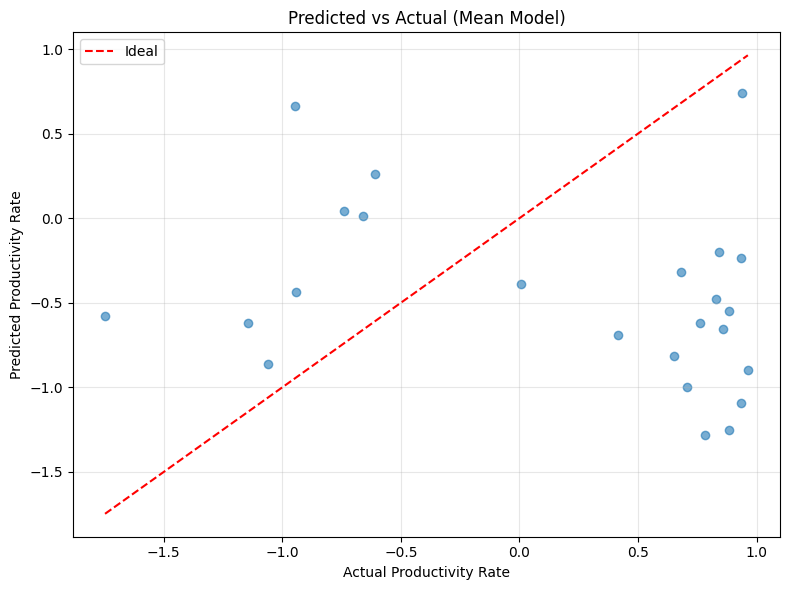

In [101]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(all_targets, all_preds, alpha=0.6)
plt.plot([min(all_targets), max(all_targets)],
         [min(all_targets), max(all_targets)],
         "r--", label="Ideal")
plt.xlabel("Actual Productivity Rate")
plt.ylabel("Predicted Productivity Rate")
plt.title("Predicted vs Actual (Mean Model)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

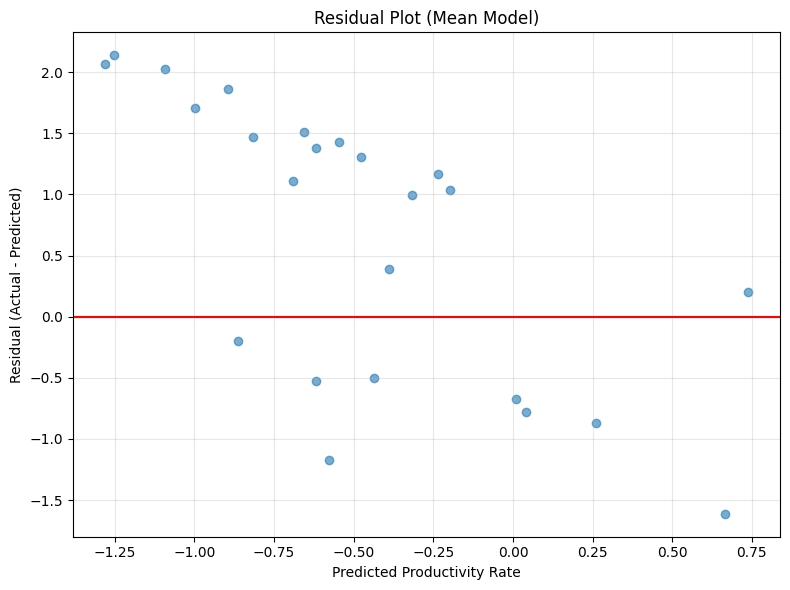

In [102]:
residuals = np.array(all_targets) - np.array(all_preds)

plt.figure(figsize=(8, 6))
plt.scatter(all_preds, residuals, alpha=0.6)
plt.axhline(0, color='red')
plt.xlabel("Predicted Productivity Rate")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residual Plot (Mean Model)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

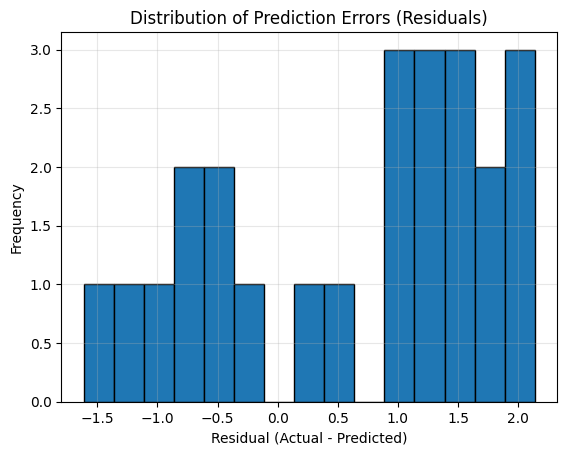

In [103]:
plt.hist(residuals, bins=15, edgecolor='black')
plt.title("Distribution of Prediction Errors (Residuals)")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.show()

### 8.5) Analysis

The mean total eggs per day is **~32,796**, with a standard deviation of** ~4,147**.  

Our model’s RMSE is **~3,858** and MAE is **~3,682**.

Since our RMSE is lower than the natural variation (std dev), **our model predicts better than simply guessing the average daily eggs**. 

This shows **we are capturing key patterns** in egg production with errors smaller than typical daily fluctuations.

### 9) Deployment Function

Function to predict productivity given the input of a new day's graph. Returns the predicted number of eggs laid

In [92]:
def predict_productivity(graph, model_path="best_model.pt"):
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = GATGraphRegressor(
        in_node_feats=graph.x.shape[1],
        in_edge_feats=graph.edge_attr.shape[1]
    )
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()

    graph = graph.to(device)

    # Disable gradient tracking
    with torch.no_grad():
        pred = model(graph)

    return pred.item()